In [1]:
import torch

torch.set_default_dtype(torch.float32)
torch.manual_seed(91021)
torch.__version__

'2.2.1+cu121'

# Synthetic Data

In [2]:
# create known parameters
weight = 0.7
bias = 0.3

# create data
X = torch.arange(0, 1, 0.002).unsqueeze(1)
# add normal noise with variance 0.1
y = weight * X + bias + (0.001**0.5) * torch.randn(X.shape)

# train/test splits
split = int(0.8 * len(X))
idx = torch.randperm(len(X))

X_train, y_train = X[idx[:split]], y[idx[:split]]
X_test, y_test = X[idx[split:]], y[idx[split:]]

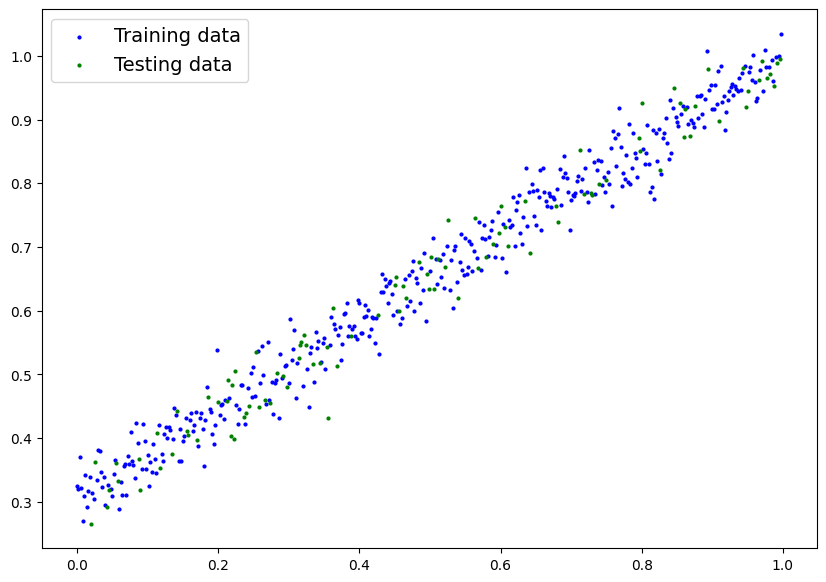

In [3]:
import matplotlib.pyplot as plt


def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,
):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


plot_predictions()

# Model

In [4]:
from torch import nn


class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return X * self.weight + self.bias

In [5]:
model_0 = LinearRegression()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3014], requires_grad=True),
 Parameter containing:
 tensor([0.6171], requires_grad=True)]

In [6]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.3014])), ('bias', tensor([0.6171]))])

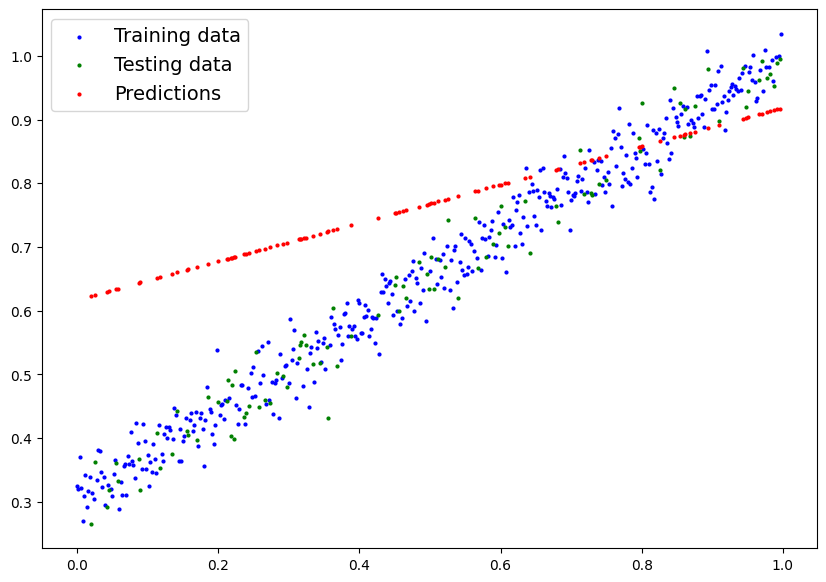

In [7]:
# make predictions
with torch.inference_mode():
    y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

# Train